In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler

In [71]:
class_map={1:0,2:1,3:2,4:3,5:4}

df=pd.read_csv('../metrics_compact.csv')
df.fillna(value = 0, inplace=True)

final = pd.get_dummies(df, columns=['usergroup'],drop_first=True)
final.drop(['chat_id','conv_id'], axis=1, inplace=True)
final['rating'] =final['rating'].astype('int32')
final.head()

,RR,RD,rating,duration,initiatedByUser,length,turnsByUser,numWords,usergroup_default
0,1.0,9.50,4,23,True,8,3,0.0,1
1,1.0,11.00,5,77,True,8,3,2.0,1
2,1.0,19.67,4,66,False,11,4,0.0,1
3,1.0,164.00,5,844,True,9,4,4.0,1
4,1.0,152.67,4,490,True,11,5,4.0,1


In [72]:
len(final), final['rating'].value_counts(), final.shape

(762,
 5    426
 0    142
 4    118
 3     36
 1     23
 2     17
 Name: rating, dtype: int64,
 (762, 9))

## Split Data

In [74]:
scaler = StandardScaler()
#scaler.fit(final.drop('rating',axis=1))
scaled_features = scaler.fit_transform(final.drop('rating',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=final.columns[:-1])

X= df_feat
y = final['rating']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25)
print(X_train.shape,y_train.shape,  'train shape')
print(X_val.shape,y_val.shape, 'validation shape')
print(X_test.shape,y_test.shape, 'test shape')

(399, 8) (399,) train shape
(134, 8) (134,) validation shape
(229, 8) (229,) test shape


In [75]:
feat_cols = []

for col in df_feat.columns:
    feat_cols.append(tf.feature_column.numeric_column(col))

In [76]:
config = tf.estimator.RunConfig().replace(keep_checkpoint_max = 5, 
                    log_step_count_steps=100, save_checkpoints_steps=200)

epochs = [60, 100]
batches = [32, 64]
drops = [0.4,0.5]
lr = [0.1,0.01, 0.001]
evaluation_list = []
for e in epochs:
    for b in batches:
        for d in drops:
            for rate in lr:
        
                input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=b,
                                                                   num_epochs=e,shuffle=False)
                dummy = tf.estimator.DNNClassifier(
                    hidden_units=[20, 30,40,60, 40,30,20], 
                    n_classes=6,
                    dropout=d,
                    batch_norm=True,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
                    feature_columns=feat_cols,
                    config=config
                    #model_dir='./output'
                )
                dummy.train(input_fn=input_fn,steps=600 )
                eval_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_val,y=y_val,batch_size=b,
                                                                   num_epochs=e,shuffle=False)
                evaluation = dummy.evaluate(input_fn=eval_fn)
                evaluation_list.append({
                    "num_epochs":e, 
                    "batch_size":b,
                    "dropout":d, 
                    "eval": evaluation,
                    "learning_rate":rate,
                    "classifier":dummy})
                print("\n ---- EVALUATION  ",evaluation)
                print("EPOCH: ",e, "BATCH SIZE: ",b, "DROPOUT",d, "LR",rate)

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpzormdao7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 200, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this war

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-02T10:00:30Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmphoaayqsk/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.78331s
INFO:tensorflow:Finished evaluation at 2020-06-02-10:00:31
INFO:tensorflow:Saving dict for global step 600: accuracy = 0.6567164, average_loss = 1.7987901, global_step = 600, loss = 1.7969089
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmphoaayqsk/model.ckpt-600

 ---- EVALUATION   {'accuracy': 0.6567164, 'average_loss': 1.7987901, 'loss': 1.7969089, 'global_step': 600}
EPOCH:  60 BATCH SIZE:  32 DROPOUT 0.4 LR 0.01
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpnphdq51e', '_tf_random_seed'

INFO:tensorflow:loss = 1.148133, step = 400 (0.416 sec)
INFO:tensorflow:global_step/sec: 364.4
INFO:tensorflow:loss = 1.2269311, step = 500 (0.275 sec)
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmp519khz3s/model.ckpt.
INFO:tensorflow:Loss for final step: 1.0774183.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-02T10:00:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:R

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpo5v9qovo/model.ckpt.
INFO:tensorflow:loss = 2.1780422, step = 0
INFO:tensorflow:global_step/sec: 154.841
INFO:tensorflow:loss = 2.117081, step = 100 (0.647 sec)
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpo5v9qovo/model.ckpt.
INFO:tensorflow:global_step/sec: 231.704
INFO:tensorflow:loss = 1.4215748, step = 200 (0.431 sec)
INFO:tensorflow:global_step/sec: 339.86
INFO:tensorflow:loss = 1.1407051, step = 300 (0.294 sec)
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpo5v9qovo/model.ckpt.
INFO:tensorflow:global_step/sec: 234.847
INFO:tensorflow:loss = 1.4964635, step = 400 (0.426 sec)
INF

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpxmuqd5j3/model.ckpt.
INFO:tensorflow:loss = 2.4279227, step = 0
INFO:tensorflow:global_step/sec: 149.19
INFO:tensorflow:loss = 1.0878062, step = 100 (0.672 sec)
INFO:tensorf

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpxpnwh50t/model.ckpt.
INFO:tensorflow:loss = 2.4612598, step = 0
INFO:tensorflow:global_step/sec: 151.328
INFO:tensorflow:loss = 1.2461555, step = 100 (0.662 sec)
INFO:tensor

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpcmh2ma53/model.ckpt.
INFO:tensorflow:loss = 2.1184082, step = 0
INFO:tensorflow:global_step/sec: 142.343
INFO:tensorflow:loss = 1.7960378, step = 100 (0.704 sec)
INFO:tensor

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmp_oq3bslc/model.ckpt.
INFO:tensorflow:loss = 2.1314769, step = 0
INFO:tensorflow:global_step/sec: 145.218
INFO:tensorflow:loss = 1.0505636, step = 100 (0.690 sec)
INFO:tensor

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpnnhjqohe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 200, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this war

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-02T10:02:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmp7mfkf8vc/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.04882s
INFO:tensorflow:Finished evaluation at 2020-06-02-10:02:20
INFO:tensorflow:Saving dict for global step 600: accuracy = 0.6567164, average_loss = 3.8870325, global_step = 600, loss = 3.885205
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmp7mfkf8vc/model.ckpt-600

 ---- EVALUATION   {'accuracy': 0.6567164, 'average_loss': 3.8870325, 'loss': 3.885205, 'global_step': 600}
EPOCH:  100 BATCH SIZE:  32 DROPOUT 0.5 LR 0.01
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpz8n5yd7m', '_tf_random_seed':

INFO:tensorflow:loss = 1.1591636, step = 400 (0.444 sec)
INFO:tensorflow:global_step/sec: 349.069
INFO:tensorflow:loss = 1.2085912, step = 500 (0.287 sec)
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpnjmt5q27/model.ckpt.
INFO:tensorflow:Loss for final step: 0.9505439.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-02T10:02:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpo_8lhhcs/model.ckpt.
INFO:tensorflow:loss = 2.4710608, step = 0
INFO:tensorflow:global_step/sec: 150.396
INFO:tensorflow:loss = 1.894448, step = 100 (0.666 sec)
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpo_8lhhcs/model.ckpt.
INFO:tensorflow:global_step/sec: 220.198
INFO:tensorflow:loss = 1.4840441, step = 200 (0.454 sec)
INFO:tensorflow:global_step/sec: 316.304
INFO:tensorflow:loss = 1.479962, step = 300 (0.316 sec)
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpo_8lhhcs/model.ckpt.
INFO:tensorflow:global_step/sec: 223.153
INFO:tensorflow:loss = 1.416918, step = 400 (0.448 sec)
INFO

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmpvad81148/model.ckpt.
INFO:tensorflow:loss = 2.4802485, step = 0
INFO:tensorflow:global_step/sec: 152.087
INFO:tensorflow:loss = 1.2073014, step = 100 (0.658 sec)
INFO:tensor

In [77]:
best_acc=0
best_eval = 0
for ev in evaluation_list:
    acc =ev.get("eval").get("accuracy")
    if acc >best_acc:
        best_acc = acc
        best_eval = ev
print("Best Accuracy: ", best_acc)
print("Best Eval: ", best_eval)

Best Accuracy:  0.6567164
Best Eval:  {'num_epochs': 60, 'batch_size': 32, 'dropout': 0.4, 'eval': {'accuracy': 0.6567164, 'average_loss': 1.7987901, 'loss': 1.7969089, 'global_step': 600}, 'learning_rate': 0.01, 'classifier': <tensorflow_estimator.python.estimator.canned.dnn.DNNClassifierV2 object at 0x160a35470>}


In [78]:
eval_df = pd.DataFrame(evaluation_list)
eval_df["Acc"] = eval_df["eval"].apply(lambda a:a.get('accuracy'))
eval_df["Loss"] = eval_df["eval"].apply(lambda a:a.get('average_loss'))
eval_df["Step"] = eval_df["eval"].apply(lambda a:a.get('global_step'))
eval_df.drop("eval", axis=1, inplace=True)
sorted_classifiers = eval_df.sort_values('Acc', ascending=False)
sorted_classifiers[:10]

,num_epochs,batch_size,dropout,learning_rate,classifier,Acc,Loss,Step
16,100,32,0.5,0.010,<tensorflow_estimator.python.estimator.canned....,0.656716,3.887033,600
22,100,64,0.5,0.010,<tensorflow_estimator.python.estimator.canned....,0.656716,3.680570,600
7,60,64,0.4,0.010,<tensorflow_estimator.python.estimator.canned....,0.656716,2.622446,375
10,60,64,0.5,0.010,<tensorflow_estimator.python.estimator.canned....,0.656716,3.982838,375
1,60,32,0.4,0.010,<tensorflow_estimator.python.estimator.canned....,0.656716,1.798790,600
13,100,32,0.4,0.010,<tensorflow_estimator.python.estimator.canned....,0.656716,2.168615,600
15,100,32,0.5,0.100,<tensorflow_estimator.python.estimator.canned....,0.559702,1.325770,600
4,60,32,0.5,0.010,<tensorflow_estimator.python.estimator.canned....,0.552239,4.102833,600
11,60,64,0.5,0.001,<tensorflow_estimator.python.estimator.canned....,0.544776,1.319007,375
2,60,32,0.4,0.001,<tensorflow_estimator.python.estimator.canned....,0.537313,1.290289,600


In [63]:
sorted_classifiers.iloc[3]

num_epochs                                                      60
batch_size                                                      64
dropout                                                        0.4
learning_rate                                                 0.01
classifier       <tensorflow_estimator.python.estimator.canned....
Acc                                                       0.761194
Loss                                                       1.68607
Step                                                           375
Name: 5, dtype: object

## Predict

In [79]:
best_classifier = best_eval.get('classifier')
second_best = sorted_classifiers.iloc[3]['classifier']


In [80]:
pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)
note_predictions = list(best_classifier.predict(input_fn=pred_fn))
note_predictions[0]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmphoaayqsk/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'logits': array([-8.416692  ,  0.2692454 , -0.40488192,  0.20739812,  2.82455   ,
         4.6071434 ], dtype=float32),
 'probabilities': array([1.8389279e-06, 1.0884768e-02, 5.5468893e-03, 1.0231971e-02,
        1.4014383e-01, 8.3319080e-01], dtype=float32),
 'class_ids': array([5]),
 'classes': array([b'5'], dtype=object),
 'all_class_ids': array([0, 1, 2, 3, 4, 5], dtype=int32),
 'all_classes': array([b'0', b'1', b'2', b'3', b'4', b'5'], dtype=object)}

In [81]:
final_preds  = []
for pred in note_predictions:
    final_preds.append(pred['class_ids'][0])
    
print("\n-----Confusion Matrix-----\n",confusion_matrix(y_test,final_preds))
print("\n-----Classification Report--\n",classification_report(y_test,final_preds))
print("Accuracy: ",accuracy_score(y_test, final_preds))


-----Confusion Matrix-----
 [[ 40   0   0   0   0   3]
 [  0   0   0   0   0   6]
 [  0   0   0   0   0   3]
 [  0   0   0   0   0  12]
 [  2   0   0   0   0  27]
 [  3   0   0   0   0 133]]

-----Classification Report--
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        43
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        29
           5       0.72      0.98      0.83       136

    accuracy                           0.76       229
   macro avg       0.27      0.32      0.29       229
weighted avg       0.60      0.76      0.66       229

Accuracy:  0.7554585152838428


/Users/pinarkaymaz/Documents/GitLab/Thesis/proactive-interaction-optimization/data-analysis/tensor/environ/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Eval:  {'num_epochs': 60, 'batch_size': 32, 'dropout': 0.5, 'eval': {'accuracy': 0.697479, 'average_loss': 0.9943402, 'loss': 0.99707997, 'global_step': 54436}, 'learning_rate': 0.01, 'classifier': <tensorflow_estimator.python.estimator.canned.dnn.DNNClassifierV2 object at 0x13f085b70>}



In [82]:
eval_fn_test = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=64,
                                                                   num_epochs=60,shuffle=False)
best_classifier.evaluate(input_fn=eval_fn_test)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-02T10:04:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8d/wqv3p6fn4n52w7ptyb8p54840000gn/T/tmphoaayqsk/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.80399s
INFO:tensorflow:Finished evaluation at 2020-06-02-10:04:02
INFO:tensorflow:Saving dict for glob

{'accuracy': 0.75545853,
 'average_loss': 1.1543909,
 'loss': 1.1542568,
 'global_step': 600}

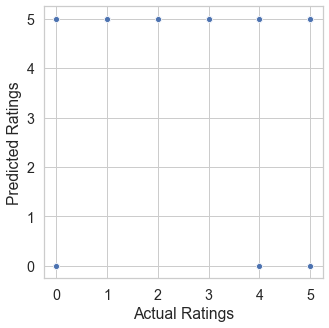

In [178]:
sns.set(font_scale = 1.3)
sns.set_style("whitegrid")
plt.figure(figsize=(5,5))

dnn_plot = sns.scatterplot(y_test, final_preds, palette='viridis')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")


dnn_plot_fig = dnn_plot.get_figure()
#dnn_plot_fig.savefig("../../documentation/images/dnn.eps", format='eps', bbox_inches='tight')

<Figure size 360x360 with 0 Axes>

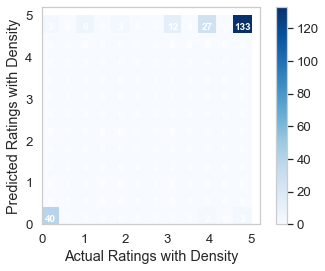

In [177]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(5,5))

fig, ax = plt.subplots()
ax.set_aspect("equal")
hist, xbins, ybins, im = ax.hist2d(y_test,final_preds, bins=12, cmap=plt.cm.Blues)

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+0.2,ybins[i]+0.12, int(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize=10)
plt.xlabel("Actual Ratings with Density")
plt.xticks([0,1,2,3,4,5,6])
plt.ylim(0,5.2)
plt.xlim(0,5.2)
plt.ylabel("Predicted Ratings with Density")
plt.colorbar(im, ax=ax)

#plt.savefig("../../documentation/images/mlp_colorbar.png",  bbox_inches='tight')

In [182]:
final_preds
X_test.iloc[0]

RR                 0.462062
RD                -0.062767
rating            -0.158458
duration          -0.436606
initiatedByUser   -0.484475
length            -0.448283
turnsByUser       -0.686403
numWords           1.010554
Name: 601, dtype: float64